# 支出側から見る景気循環

## 始める前に

次のセルの１行目以外をアンコメント（`# `を削除）しなさい。アンコメントするには次の手順に従う。
* Windowsの場合：１行目以外の全ての行を選択し，`Ctrl`を押したまま`/`を押す。
* Macの場合：１行目以外の全ての行を選択し，`command`を押したまま`/`を押す。

In [30]:
# CELL PROVIDED
# import piplite
# await piplite.install(['py4macro','japanize-matplotlib-jlite'])
# %matplotlib inline
# import statsmodels
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (4, 3)

次のコードを実行しなさい。

In [31]:
# CELL PROVIDED
import japanize_matplotlib_jlite
import numpy as np
import pandas as pd
import py4macro
import statsmodels.formula.api as smf

np.set_printoptions(legacy='1.21')

## はじめに

### 準備

In [32]:
# CELL PROVEDED
# 使用する変数
var_lst = ['gdp', 'consumption', 'investment', 'government', 'exports', 'imports']

df = py4macro.data('jpn-q')[var_lst]

# 各変数の変動を計算、cols_log_trendとcols_cycleを作成
trend_lst = []       # トレンドの変数リスト
cycle_lst = []       # 変動の変数リスト

for c in var_lst:

    name_log_trend = c+'_log_trend'
    name_trend = c+'_trend'
    name_cycle = c+'_cycle'
    
    df[name_log_trend] = py4macro.trend( np.log(df[c]) )             # 対数トレンド
    df[name_trend] = np.exp( df[name_log_trend] )                    # 水準トレンド
    df[name_cycle] = 100 * ( np.log( df[c] ) - df[name_log_trend] )  # ％乖離
    
    trend_lst.append( name_trend )
    cycle_lst.append( name_cycle )

In [33]:
# CELL PROVEDED
var_lst  # 変数のリスト

['gdp', 'consumption', 'investment', 'government', 'exports', 'imports']

In [34]:
# CELL PROVIDED
trend_lst       # 水準トレンドのリスト（対数トレンドではない！）

['gdp_trend',
 'consumption_trend',
 'investment_trend',
 'government_trend',
 'exports_trend',
 'imports_trend']

In [35]:
# CELL PROVIDED
cycle_lst      # 変動のリスト

['gdp_cycle',
 'consumption_cycle',
 'investment_cycle',
 'government_cycle',
 'exports_cycle',
 'imports_cycle']

### GDPの変動

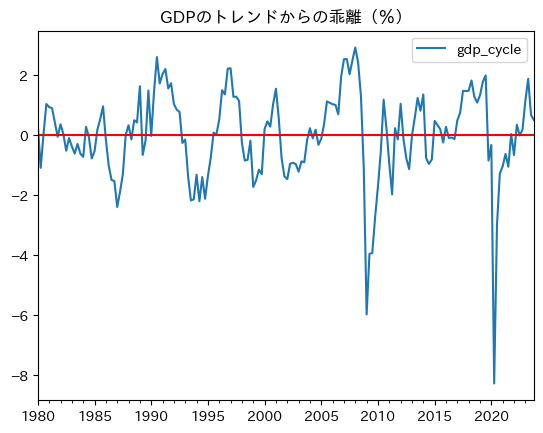

In [36]:
ax = df.plot(y='gdp_cycle', title='GDPのトレンドからの乖離（％）')
ax.axhline(0, c='red')
pass

このトピックでは、GDPトレンドの％乖離の要因を考察する。
GDPの三面等価の原則は次式を意味する。
```
生産側GDP = 支出側GDP = 分配側GDP
```
この原則は、景気循環は`3`つの側面からアプローチすることができることを意味する。
ここでは支出側GDPに着目する。
支出側GDPは次の所得恒等式で与えられる。

$$
Y_t=C_t+I_t+G_t+X_t-M_t
\tag{1}
$$

* $Y_t$：GDP（Gross Domestic Product; 支出側国内総生産）
* $C_t$：消費
* $I_t$：投資
* $G_t$：政府支出
* $X_t$：輸出
* $M_t$：輸入

上のプロットと式(1)を踏まえて、次のように考えよう。
* $C_t$、$I_t$、$G_t$，$X_t$、$M_t$は何らかの経済学的なメカニズムによって決定される　$\Rightarrow$　データにはランダムな値として現れる。
    * 右辺の総支出はランダム　$\Rightarrow$　左辺の$Y_t$はランダム

要するに、式(1)の左辺の支出側GDPの変動は、右辺にある`5`つの変数の変動によって引き起こされていると解釈できる。
もちろん、右辺の変数の変動は総需要と総供給の均衡の結果と捉える必要がある。
この点を踏まえて、次の問いを考えてみよう。

> $Y_t$（支出側GDP）の変動は何％が$C_t$、$I_t$、$G_t$、$X_t$、$M_t$の変動に起因しているか？

答えを出すためには、データを使った定量的なアプローチが要求される。
まずヒントになるのは、各支出要素の変動を比べてみることだろう。

変数         変動の標準偏差(GDPの変動の標準偏差＝１）
---------------------------------------------
gdp_cycle             1.00
consumption_cycle     0.81
investment_cycle      3.15
government_cycle      0.89
exports_cycle         3.76
imports_cycle         3.26


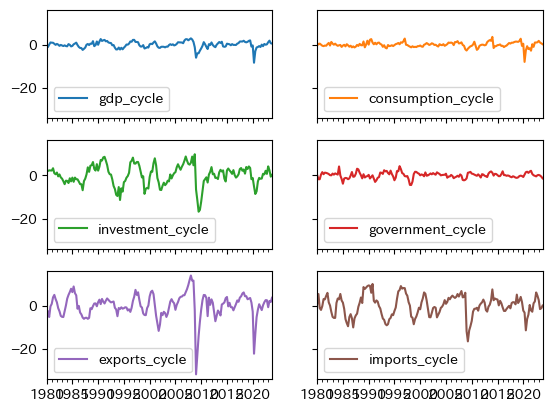

In [37]:
# CELL PROVEDED
print('変数',' '*7, '変動の標準偏差(GDPの変動の標準偏差＝１）')
print('-'*45)

for c in cycle_lst:
    var = df[c].std() / df['gdp_cycle'].std()
    print(f'{c:<19}{var:>7.2f}')

# プロット
df[cycle_lst].plot(subplots=True, layout=(3,2),
                    sharey=True     # 縦軸のスケールを同じに設定
                   )
pass

この結果は、直観的には、投資、輸出、輸入が大きな影響を与え、消費と政府支出は小さな影響しか及ぼさない、という結論を意味しているようにみえる。
本当にそうなのだろうか？

* では何％？
* 消費は？政府支出は？純輸出は？
* 相関の役割は？

In [38]:
# CELL PROVIDED
print('GDPとの相関係数')
print('-'*20)
for c in var_lst[1:]:
    corr = df[[c+'_cycle', 'gdp_cycle']].corr().iloc[0,1]
    print(f'{c}: {corr:.5f}')

GDPとの相関係数
--------------------
consumption: 0.76759
investment: 0.78030
government: -0.17090
exports: 0.75547
imports: 0.64719


## 景気循環の支出側要素分解

### 定量的な問い

各変数のトレンドは`＊`の添え字がついた次式で与えられるとする。

$$
Y_{t}^{*}=C_{t}^{*}+I_{t}^{*}+G_{t}^{*}+X_{t}^{*}-M_{t}^{*}
\tag{2}
$$

式(1)と(2)を使い次の簡単な計算をしよう。

* 式(1)と式(2)の両辺の差を取る。

$$
(Y_t-Y_{t}^{*})=
(C_t-C_{t}^{*})+(I_t-I_{t}^{*})+(G_t-G_{t}^{*})+(X_t-X_{t}^{*})-(M_t-M_{t}^{*})
$$

* 両辺を$Y_{t}^{*}$で除する。

$$
\frac{Y_t-Y_{t}^{*}}{Y_{t}^{*}}=
\frac{C_t-C_{t}^{*}}{Y_{t}^{*}}+
\frac{I_t-I_{t}^{*}}{Y_{t}^{*}}+
\frac{G_t-G_{t}^{*}}{Y_{t}^{*}}+
\frac{X_t-X_{t}^{*}}{Y_{t}^{*}}-
\frac{M_t-M_{t}^{*}}{Y_{t}^{*}}
$$

* 両辺を`100`倍する。

$$
y_t=c_t+i_t+g_t+x_t-m_t
\tag{3}
$$

ここで
$$
\begin{aligned}
&y_t\equiv100\times\dfrac{Y_t-Y_{t}^{*}}{Y_{t}^{*}}=\text{GDPのトレンドからの％乖離}\\
&c_t\equiv100\times\dfrac{C_t-C_{t}^{*}}{C_{t}^{*}}\cdot\dfrac{C_t^{*}}{Y_{t}^{*}}
    =\left(
        \begin{split} &\text{消費のトレンド}\\ &\text{からの％乖離} \end{split} 
    \right)
    \times
    \left(
        \begin{split} &\text{GDPトレンドにおける}\\ &\text{消費トレンドの割合} \end{split} 
    \right)\\
&i_t\equiv100\times\dfrac{I_t-I_{t}^{*}}{I_{t}^{*}}\cdot\dfrac{I_t^{*}}{Y_{t}^{*}}
    =\left(
        \begin{split} &\text{投資のトレンド}\\ &\text{からの％乖離} \end{split} 
    \right)
    \times
    \left(
        \begin{split} &\text{GDPトレンドにおける}\\ &\text{投資トレンドの割合} \end{split} 
    \right)\\
&g_t\equiv100\times\dfrac{G_t-G_{t}^{*}}{G_{t}^{*}}\cdot\dfrac{G_t^{*}}{Y_{t}^{*}}
    =\left(
        \begin{split} &\text{政府支出のトレンド}\\ &\text{からの％乖離} \end{split} 
    \right)
    \times
    \left(
        \begin{split} &\text{GDPトレンドにおける}\\ &\text{政府支出トレンドの割合} \end{split} 
    \right)\\
&x_t\equiv100\times\dfrac{X_t-X_{t}^{*}}{X_{t}^{*}}\cdot\dfrac{X_t^{*}}{Y_{t}^{*}}
    =\left(
        \begin{split} &\text{輸出のトレンド}\\ &\text{からの％乖離} \end{split} 
    \right)
    \times
    \left(
        \begin{split} &\text{輸出トレンドにおける}\\ &\text{輸出トレンドの割合} \end{split} 
    \right)\\
&m_t\equiv100\times\dfrac{M_t-M_{t}^{*}}{M_{t}^{*}}\cdot\dfrac{M_t^{*}}{M_{t}^{*}}
    =\left(
        \begin{split} &\text{輸入のトレンド}\\ &\text{からの％乖離} \end{split} 
    \right)
    \times
    \left(
        \begin{split} &\text{輸入トレンドにおける}\\ &\text{輸入トレンドの割合} \end{split} 
    \right)
\end{aligned}
$$

以下の計算では次の近似を使う。

$$
\dfrac{C_t-C_{t}^{*}}{C_{t}^{*}}
\approx
\text{consumption\_cycle}
$$

他の変数も同様。

### 分散分解

**＜分散と共分散＞**
* $x$の分散：$\text{Var}(x)$（variance）
* $x$と$y$の共分散：$\text{Cov}(x,y)$（covariance）

**＜分散分解＞**

式(3)の左辺を次のように変形するして$y_t$の分散分解をおこなう。

$$
\begin{align}
\text{Var}(y_t)
&=\text{Cov}(y_t,y_t)\\
&=\text{Cov}(y_t,c_t+i_t+g_t+x_t-m_t)\\
&=\text{Cov}(y_t,c_t)+\text{Cov}(y_t,i_t)+\text{Cov}(y_t,g_t)+\text{Cov}(y_t,x_t)+\text{Cov}(y_t,-m_t)\\
&=\text{Cov}(y_t,c_t)+\text{Cov}(y_t,i_t)+\text{Cov}(y_t,g_t)+\text{Cov}(y_t,x_t)-\text{Cov}(y_t,m_t)\\
&=[c_t\text{による}y_t\text{の変動}]\\
 &\quad+[i_t\text{による}y_t\text{の変動}]\\
 &\quad+[g_t\text{による}y_t\text{の変動}]\\
 &\quad+[x_t\text{による}y_t\text{の変動}]\\
 &\quad-[m_t\text{による}y_t\text{の変動}]
 \tag{4}
\end{align}
$$

**＜計算の突合＞**

実は，式(4)の等号は成立しない。

$$
\text{Var}(y_t)
\ne
[c_t\text{による}y_t\text{の変動}]+[i_t\text{による}y_t\text{の変動}]
 +[g_t\text{による}y_t\text{の変動}]+[x_t\text{による}y_t\text{の変動}]
 -[m_t\text{による}y_t\text{の変動}]
$$

理由は２つある。
* 式(1)は理論上成立するが，データでは必ずしも成立しない。実質GDPと各需要項目は「連鎖価格」となっているためであり，詳細は[ここのサイト](https://py4macro.github.io/10_Data_Fluctuation.html)にある説明を参照しよう。
* GDPと各需要要素のトレンドは個別に計算しているため，式(2)は必ずしも成立しない。

この問題の対処方法として，以下では，$\text{Var}(y_t)$の代わりに，式(4)の右辺を**支出要素の変動の合計**として$\overline{\text{Var}}(y_t)$を次のように定義する。

$$
\overline{\text{Var}}(y_t)=
[c_t\text{による}y_t\text{の変動}]+[i_t\text{による}y_t\text{の変動}]
+[g_t\text{による}y_t\text{の変動}]+[x_t\text{による}y_t\text{の変動}]
-[m_t\text{による}y_t\text{の変動}]
\tag{5}
$$

**＜各要素の貢献度＞**

式(5)の両辺を$\overline{\text{Var}}(y_t)$で割る

$$
\begin{aligned}
&c_t\text{の寄与度}=\frac{c_t\text{による}y_t\text{の変動}}{\text{支出要素の変動の合計}}
=\frac{\text{Cov}(y_t,c_t)}{\overline{\text{Var}}(y_t)}\\
&i_t\text{の寄与度}=\frac{i_t\text{による}y_t\text{の変動}}{\text{支出要素の変動の合計}}
=\frac{\text{Cov}(y_t,i_t)}{\overline{\text{Var}}(y_t)}\\
&g_t\text{の寄与度}=\frac{g_t\text{による}y_t\text{の変動}}{\text{支出要素の変動の合計}}
=\frac{\text{Cov}(y_t,g_t)}{\overline{\text{Var}}(y_t)}\\
&x_t\text{の寄与度}=\frac{x_t\text{による}y_t\text{の変動}}{\text{支出要素の変動の合計}}
=\frac{\text{Cov}(y_t,x_t)}{\overline{\text{Var}}(y_t)}\\
&m_t\text{の寄与度}=-\frac{m_t\text{による}y_t\text{の変動}}{\text{支出要素の変動の合計}}
=-\frac{\text{Cov}(y_t,m_t)}{\overline{\text{Var}}(y_t)}
\end{aligned}
$$

これらを計算することにより、各要素が$y_t$の変動に何％貢献しているかを数量化する。

### データ

上で読み込んだデータ`df`には次の変数が含まれている。
* 期間：1980年Q1〜
* `gdp`：国内総生産（支出側）
* `consumption`：消費
* `investment`：投資
* `government`：政府支出
* `net_exports`：純輸出

支出要素

In [39]:
var_lst

['gdp', 'consumption', 'investment', 'government', 'exports', 'imports']

支出要素のトレンド

In [40]:
trend_lst

['gdp_trend',
 'consumption_trend',
 'investment_trend',
 'government_trend',
 'exports_trend',
 'imports_trend']

支出要素の変動

In [41]:
cycle_lst

['gdp_cycle',
 'consumption_cycle',
 'investment_cycle',
 'government_cycle',
 'exports_cycle',
 'imports_cycle']

式(3)の変数のリストを作成

In [42]:
col_lst = ['yt', 'ct', 'it', 'gt', 'xt', 'mt']

## 各支出要素の寄与度の計算

### 計算準備

次に，式(3)の右辺の変数を作成する。

In [43]:
# CELL PROVIDED

for c, var, cycle, trend in zip( col_lst,      # 式(3)の変数
                                 var_lst,      # 変数のリスト
                                 cycle_lst,    # 変動のリスト
                                 trend_lst ):  # トレンドのリスト

    # 式(3)の右辺の各項の計算
    # imports以外
    if var != 'imports':    
        df[c] = df[cycle] * df[trend] / df['gdp_trend'] 

    # importsの場合
    else:  
        df[c] = - df[cycle] * df[trend] / df['gdp_trend'] 

df[col_lst].head()

,yt,ct,it,gt,xt,mt
,,,,,,
1980-01-01,0.326920,0.443173,0.450056,0.012075,-0.148152,-0.067145
1980-04-01,-1.084502,0.047991,0.456486,-0.503349,-0.177071,-0.475712
1980-07-01,0.045698,0.298050,0.519955,-0.504285,-0.370901,0.100131
1980-10-01,1.046795,0.017579,0.511009,0.075976,-0.026380,0.172901
1981-01-01,0.944113,-0.259638,0.496601,0.376232,0.060191,0.017762


これらの変数の分散共分散を計算しよう。

In [44]:
vcov = df[col_lst].cov()
vcov

,yt,ct,it,gt,xt,mt
yt,2.200185,0.753133,1.163513,-0.081881,0.936363,-0.634738
ct,0.753133,0.437992,0.292662,-0.015211,0.256092,-0.216855
it,1.163513,0.292662,1.022414,-0.122117,0.394536,-0.489369
gt,-0.081881,-0.015211,-0.122117,0.113976,-0.061743,0.029445
xt,0.936363,0.256092,0.394536,-0.061743,0.661460,-0.321413
mt,-0.634738,-0.216855,-0.489369,0.029445,-0.321413,0.390178


計算準備の最後に，$\overline{\text{Var}}(y_t)$を計算するために需要要素の変動の合計を`gdp_cycle_var`に割り当てる。

In [45]:
gdp_cycle_var_bar = vcov.iloc[1:,0].sum()
gdp_cycle_var_bar

2.136391153704996

### 消費

$$
c_t\text{の寄与度}=\frac{c_t\text{による}y_t\text{の変動}}{\text{需要要素の変動の合計}}
=\frac{\text{Cov}(c_t,y_t)}{\overline{\text{Var}}(y_t)}
$$

In [46]:
c_kiyo = vcov.iloc[1,0] / gdp_cycle_var_bar
c_kiyo

0.35252572215588684

### 投資

$$
i_t\text{の寄与度}=\frac{i_t\text{による}y_t\text{の変動}}{y_t\text{需要要素の変動の合計}}
=\frac{\text{Cov}(i_t,y_t)}{\overline{\text{Var}}(y_t)}
$$

In [47]:
i_kiyo = vcov.iloc[2,0] / gdp_cycle_var_bar
i_kiyo

0.5446163032500767

### 政府支出

$$
g_t\text{の寄与度}=\frac{g_t\text{による}y_t\text{の変動}}{y_t\text{需要要素の変動の合計}}
=\frac{\text{Cov}(g_t,y_t)}{\overline{\text{Var}}(y_t)}
$$

In [48]:
g_kiyo = vcov.iloc[3,0] / gdp_cycle_var_bar
g_kiyo

-0.038326663356062454

### 輸出

$$
x_t\text{の寄与度}=\frac{x_t\text{による}y_t\text{の変動}}{y_t\text{需要要素の変動の合計}}
=\frac{\text{Cov}(x_t,y_t)}{\overline{\text{Var}}(y_t)}
$$

In [49]:
x_kiyo = vcov.iloc[4,0] / gdp_cycle_var_bar
x_kiyo

0.43829212701734493

### 輸入

$$
m_t\text{の寄与度}=\frac{m_t\text{による}y_t\text{の変動}}{y_t\text{需要要素の変動の合計}}
=-\frac{\text{Cov}(y_t,m_t)}{\overline{\text{Var}}(y_t)}
$$

In [50]:
m_kiyo = vcov.iloc[5,0] / gdp_cycle_var_bar
m_kiyo

-0.2971074890672459

### 確認

In [51]:
# CELL PROVIDED
c_kiyo + i_kiyo + g_kiyo + x_kiyo + m_kiyo

1.0000000000000002

### 負の寄与度とは？

政府支出の寄与度

In [52]:
g_kiyo

-0.038326663356062454

政府支出はGDPの変動を抑えるている。政府は経済を安定化させるために、政府支出を調整している。景気が悪くなれば、政府支出を増やし景気後退を防ごうとするし、景気が良くなれば、オーバーヒートして高インフレが発生しないように、支出を制限すると想定される。そのような行動が、数字に表れている。

輸入の寄与度

In [53]:
m_kiyo

-0.2971074890672459

輸入の負の値は、政府支出と同様に、GDPの変動を抑える効果があることを示している。
この効果は、**自動安定化装置**の一つのメカニズムとなる。
分散共分散行列`vcov`を使い、GDPと輸入の相関係数を示してみよう。

In [54]:
df[['gdp_cycle', 'imports_cycle']].corr().iloc[0,1]

0.6471921940476375

GDPの変動と輸入の変動には正の相関があることが分かる。
直観的には、所得が増えると消費や投資に使う輸入財が増えるということだ。
これを踏まえて、所得高等式をの中で $M_t$ の前にマイナスの符号がある理由を考えてみよう。

$$
Y_t=C_t+I_t+G_t+X_t-M_t
$$

GDPは**国内**総生産であり、三面等価の原則により
```
生産側GDP ＝ 支出側GDP ＝ 分配GDP
```
となる。即ち、国内で生産された財・サービスに対する支出の合計が支出側GDPとなる。
所得高等式の $C_t$、$I_t$、$G_t$ には各支出項目の総支出を表しているため、外国で生産されて輸入された財・サービスである $M_t$ を控除している。
マイナスの符号があることにより、次のようなメカニズムが働くことになる。

* 景気上昇期　→　$Y_t\uparrow$　→　$M_t\uparrow$　→　$-M_t$により$Y_t\uparrow$を抑える効果
* 景気後退期　→　$Y_t\downarrow$　→　$M_t\downarrow$　→　$-M_t$により$Y_t\downarrow$を抑える効果

これによりGDPの変動を抑制することになる。
輸入の寄与度は約`-0.3`であり、輸入を通した自動安定化装置の効果は小さくないことを示している。
どれほどの大きさになるのかを考えるために、次のように定義する純輸出の寄与度を考えてみよう。
```
純輸出の寄与度 ＝ 純輸出の寄与度 ＋ 輸入の寄与度
```

In [55]:
netx_kiyo = x_kiyo + m_kiyo
netx_kiyo

0.14118463795009906

輸出の寄与度は約`0.4`を超えているが、輸入の安定化効果を考慮すると、約`0.14`まで減少することになる。

```{note}
他の自動安定化装置として次のものがあるが、上の分析では各支出項目の変動に含まれていると解釈できる。
換言すると、自動安定化装置を排除すると
* 所得税：$C_t$を通して$Y_t$の変動に影響する。
* 法人税：$I_t$を通して$Y_t$の変動に影響する。
* 消費税：$C_t$と$I_t$を通して$Y_t$の変動に影響する。
* 失業給付：含まれていない。
```

### 結果

In [56]:
# CELL PROVIDED

print('GDPの変動に対する寄与度')
print('-'*20)

new_var_lst = var_lst[1:] + ['net_exports']
kiyo_lst = [c_kiyo, i_kiyo, g_kiyo, x_kiyo, m_kiyo, netx_kiyo]

for var, kiyo in zip( new_var_lst, kiyo_lst ):

    print(f'{var:>11} {kiyo:>6.1%}')

GDPの変動に対する寄与度
--------------------
consumption  35.3%
 investment  54.5%
 government  -3.8%
    exports  43.8%
    imports -29.7%
net_exports  14.1%


* 消費の寄与度は思ったより高いのでは。
* 消費より投資の寄与度が高く，GDP変動の半分以上が投資の変動に起因する。
* 政府支出は景気循環を軽減する。しかし，その寄与度は投資や消費と比較すると大きくはない。
* 輸入の安定化効果は大きく、輸出の変動を大きく抑えている。

最初の印象と大きく違う理由
* 負の寄与度

そして
* 「重み」の大きさが違う。

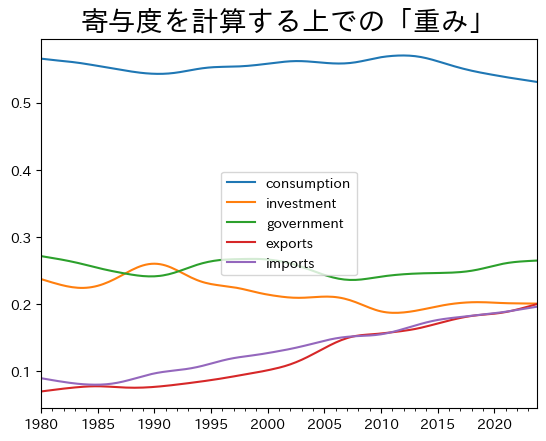

In [57]:
# CELL PROVIDED
ax_ = ( df['consumption_trend']/df['gdp_trend'] ).plot(label='consumption')

for c, trend in zip( var_lst[2:], trend_lst[2:] ):

    weight = ( df[trend] / df['gdp_trend'] )
    weight.plot(label=c, ax=ax_)
    
ax_.legend()
ax_.set_title('寄与度を計算する上での「重み」', size=20)
pass

平均を計算してみよう。

In [58]:
# CELL PROVIDED
for c, trend in zip( var_lst[1:], trend_lst[1:] ):

    weight = ( df[trend] / df['gdp_trend'] ).mean()
    print(f'{c:<11} {weight:.3f}')

consumption 0.555
investment  0.217
government  0.253
exports     0.123
imports     0.134


* 消費の重みの平均が大きい。従って、消費の変動は比較的に小さいが、重みが大きいためGDPの変動への貢献が大きくなっている。
* 投資の変動は大きい。しかし、重みが約`20`％しかないため、GDPの変動への貢献が小さくなっている。
* 政府支出の重みは投資よりも大きいが、GDPの変動を軽減する効果は限定的のようである。